<a href="https://colab.research.google.com/github/lazarussim12-beep/DLI_GRP_Assignment/blob/main/Lazarus%20Method%20Version%208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and import all required library


In [1]:
import os
import re
import time
import zipfile
import pickle
import random

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.svm import SVC

import xgboost as xgb
import lightgbm as lgb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    GlobalMaxPooling1D,
    GlobalAveragePooling1D,
    Dense,
    Dropout,
    LSTM,
    Bidirectional,
    GRU,
)
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import joblib

# Import Dataset


--2025-08-15 09:46:51--  https://github.com/lazarussim12-beep/DLI_GRP_Assignment/raw/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lazarussim12-beep/DLI_GRP_Assignment/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip [following]
--2025-08-15 09:46:51--  https://raw.githubusercontent.com/lazarussim12-beep/DLI_GRP_Assignment/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15642124 (15M) [application/zip]
Saving to: ‘enron_spam_data.zip.1’

enron_spam_data.zip 100%

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14



Column names: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']

=== SPAM vs HAM Analysis ===
Using column: 'Spam/Ham'
Counts by category:
Spam/Ham
spam    17171
ham     16545
Name: count, dtype: int64

Percentages by category:
spam: 50.93%
ham: 49.07%

Detailed Analysis:
Total emails: 33716
ham: 16545 emails (49.07%)
spam: 17171 emails (50.93%)


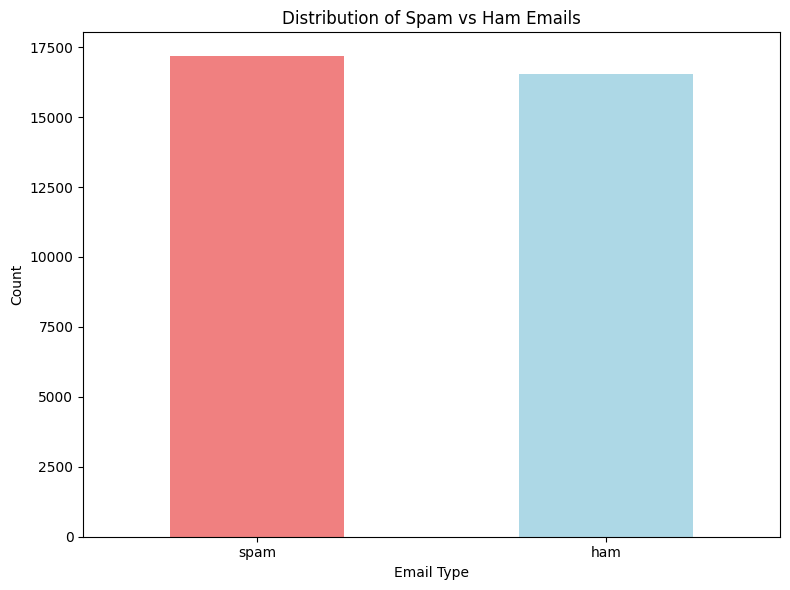

In [2]:
# Download the zip file from GitHub
!wget https://github.com/lazarussim12-beep/DLI_GRP_Assignment/raw/ecfaa17f2bf89a0e65e30e678d9dc03715c4e8d5/enron_spam_data.zip

# Unzip the file
import zipfile
with zipfile.ZipFile('enron_spam_data.zip', 'r') as zip_ref:
    zip_ref.extractall('enron_data')

# List extracted files (to verify)
import os
extracted_files = os.listdir('enron_data')
print("Extracted files:", extracted_files)

# Load the CSV file(s) into pandas
import pandas as pd

for file in extracted_files:
    if file.endswith('.csv'):
        df = pd.read_csv(f'enron_data/{file}')
        print(f"Loaded {file} with shape:", df.shape)

        # Display first few rows
        display(df.head())

        print(f"\nColumn names: {df.columns.tolist()}")

        # Calculate number of spam and ham in the Spam/Ham column
        print("\n=== SPAM vs HAM Analysis ===")

        spam_col = None
        for col in df.columns:
            if 'spam' in col.lower() or 'ham' in col.lower():
                spam_col = col
                break

        if spam_col is None:
            spam_col = df.columns[3] if len(df.columns) > 3 else df.columns[-1]

        print(f"Using column: '{spam_col}'")

        # Count values in the spam/ham column
        spam_ham_counts = df[spam_col].value_counts()
        print("Counts by category:")
        print(spam_ham_counts)

        # Calculate percentages
        spam_ham_percentages = df[spam_col].value_counts(normalize=True) * 100
        print("==========================")
        print("\nPercentages by category:")
        for category, percentage in spam_ham_percentages.items():
            print(f"{category}: {percentage:.2f}%")

        # More detailed analysis
        total_emails = len(df)
        print("==========================")
        print(f"\nDetailed Analysis:")
        print(f"Total emails: {total_emails}")

        for category in df[spam_col].unique():
            count = (df[spam_col] == category).sum()
            percentage = (count / total_emails) * 100
            print(f"{category}: {count} emails ({percentage:.2f}%)")

        try:
            import matplotlib.pyplot as plt

            plt.figure(figsize=(8, 6))
            spam_ham_counts.plot(kind='bar', color=['lightcoral', 'lightblue'])
            plt.title('Distribution of Spam vs Ham Emails')
            plt.xlabel('Email Type')
            plt.ylabel('Count')
            plt.xticks(rotation=0)
            plt.tight_layout()
            plt.show()

        except ImportError:
            print("\nMatplotlib not available for visualization")

        break

# Lazarus Sim Wen Hui Code


In [ ]:
# df['Message'] = df['Message'].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
# df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})
# X = df['Message'].values
# y = df['Spam/Ham'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # Tokenization and padding
# max_words = 10000
# max_len = 100
# tokenizer = Tokenizer(num_words=max_words)
# tokenizer.fit_on_texts(X_train)
# X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
# X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# # CNN feature extractor model
# model = Sequential([
#     Embedding(max_words, 128, input_length=max_len),
#     Conv1D(128, 5, activation='relu'),
#     Dropout(0.3),
#     Conv1D(64, 3, activation='relu'),
#     GlobalMaxPooling1D(),
#     Dropout(0.3),
#     Dense(64, activation='relu'),
#     Dropout(0.3),
#     Dense(1, activation='sigmoid')
# ])
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train CNN feature extractor
# start_time = time.time()
# model.fit(
#     X_train_seq, y_train,
#     batch_size=32,
#     epochs=5,
#     validation_split=0.1,
#     verbose=2
# )

# # Extract CNN features
# feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[4].output)
# X_train_cnn_feat = feature_extractor.predict(X_train_seq)
# X_test_cnn_feat = feature_extractor.predict(X_test_seq)

# # TF-IDF features with n-grams
# vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
# X_train_tfidf = vectorizer.fit_transform(X_train)
# X_test_tfidf = vectorizer.transform(X_test)

# # Logistic Regression on TF-IDF
# lr = LogisticRegression(max_iter=1000)
# lr.fit(X_train_tfidf, y_train)
# proba_lr = lr.predict_proba(X_test_tfidf)[:, 1]

# # Logistic Regression on CNN features
# lr_cnn_only = LogisticRegression(max_iter=1000)
# lr_cnn_only.fit(X_train_cnn_feat, y_train)
# proba_cnn = lr_cnn_only.predict_proba(X_test_cnn_feat)[:, 1]

# # XGBoost
# xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
# xgb_model.fit(X_train_tfidf, y_train)
# proba_xgb = xgb_model.predict_proba(X_test_tfidf)[:, 1]

# # LightGBM
# lgb_model = lgb.LGBMClassifier()
# lgb_model.fit(X_train_tfidf, y_train)
# proba_lgb = lgb_model.predict_proba(X_test_tfidf)[:, 1]

# # Soft Voting Ensemble
# ensemble_soft_no_rf_proba = (proba_xgb + proba_lgb + proba_cnn + proba_lr) / 4
# ensemble_soft_no_rf_pred = (ensemble_soft_no_rf_proba > 0.5).astype(int)
# acc_ensemble_soft_no_rf = accuracy_score(y_test, ensemble_soft_no_rf_pred)
# report_ensemble_soft_no_rf = classification_report(y_test, ensemble_soft_no_rf_pred, target_names=['Ham', 'Spam'], output_dict=True)
# f1_ham_ensemble_soft_no_rf = report_ensemble_soft_no_rf['Ham']['f1-score']
# f1_spam_ensemble_soft_no_rf = report_ensemble_soft_no_rf['Spam']['f1-score']
# avg_f1_ensemble_soft_no_rf = (f1_ham_ensemble_soft_no_rf + f1_spam_ensemble_soft_no_rf) / 2

# # Print the results table with F1 scores and average F1
# print("\nResults Table:")
# print("+------------------------------------------------------+----------+----------+----------+----------+")
# print("| Model                                                | Accuracy | F1 Ham   | F1 Spam  | Avg F1   |")
# print("+------------------------------------------------------+----------+----------+----------+----------+")
# print(f"| Ensemble (TF-IDF + XGB + LGB + CNN + LR, Soft Vote)  |   {acc_ensemble_soft_no_rf:.2f}   |  {f1_ham_ensemble_soft_no_rf:.2f}    |  {f1_spam_ensemble_soft_no_rf:.2f}    |  {avg_f1_ensemble_soft_no_rf:.2f}    |")
# print("+------------------------------------------------------+----------+----------+----------+----------+")
# print("TF-IDF: Term Frequency-Inverse Document Frequency with N-grams (1-3)")
# print("XGB: XGBoost on TF-IDF features")
# print("LGB: LightGBM on TF-IDF features")
# print("CNN: Convolutional Neural Network with Logistic Regression")
# print("LR: Logistic Regression on TF-IDF features")

# time_taken = time.time() - start_time
# minutes = int(time_taken // 60)
# seconds = time_taken % 60
# print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
759/759 - 13s - 18ms/step - accuracy: 0.9255 - loss: 0.1682 - val_accuracy: 0.9789 - val_loss: 0.0643
Epoch 2/5
759/759 - 12s - 16ms/step - accuracy: 0.9841 - loss: 0.0461 - val_accuracy: 0.9778 - val_loss: 0.0683
Epoch 3/5
759/759 - 3s - 3ms/step - accuracy: 0.9910 - loss: 0.0267 - val_accuracy: 0.9807 - val_loss: 0.0677
Epoch 4/5
759/759 - 6s - 8ms/step - accuracy: 0.9943 - loss: 0.0183 - val_accuracy: 0.9818 - val_loss: 0.0738
Epoch 5/5
759/759 - 6s - 8ms/step - accuracy: 0.9950 - loss: 0.0157 - val_accuracy: 0.9804 - val_loss: 0.0875
843/843 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:48:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 13736, number of negative: 13236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.562023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 917311
[LightGBM] [Info] Number of data points in the train set: 26972, number of used features: 9970
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509269 -> initscore=0.037080
[LightGBM] [Info] Start training from score 0.037080


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, Params, Inference Time
Model                               Accuracy   Precision  Recall     F1         Params     Inference (ms) 
------------------------------------------------------------------------------------------------------------------------
Logistic Regression (TF-IDF)        0.99       0.98       0.99       0.99       10001      2.28           
Logistic Regression (CNN)           0.98       0.98       0.99       0.98       65         1.34           
XGBoost                             0.98       0.97       0.99       0.98       10000      30.98          
LightGBM                            0.98       0.97       0.99       0.98       10000      84.79          
Ensemble (XGB+LGB+CNN+LR)           0.99       0.98       1.00       0.99       Combined   119.40         
------------------------------------------------------------------------------------------------------------------------
TF-IDF: Term Frequency-Inverse Docu

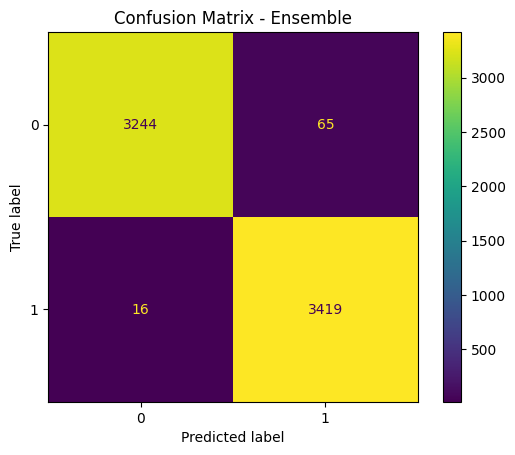

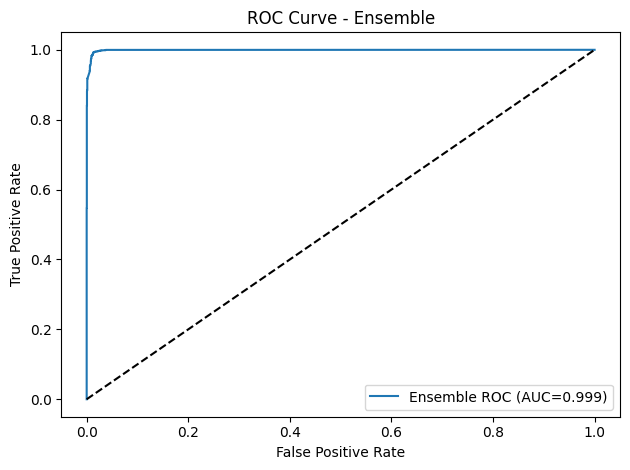


Total runtime: 213.54 seconds (3 minutes 33.54 seconds)
Achieved F1 (Ensemble) = 0.99. Target met
Saving models with optimized file count...
✓ CNN models saved as .h5 files
✓ All other models bundled in ensemble_model_bundle.pkl

🎉 Models saved successfully!
Files created:
  - cnn_model.h5 & feature_extractor.h5 (CNN models in native format)
  - ensemble_model_bundle.pkl (all other models & preprocessors)


In [3]:
# Reproducibility: fix random seeds
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

df['Message'] = df['Message'].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})
X = df['Message'].values
y = df['Spam/Ham'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Tokenization and padding
max_words = 10000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# CNN feature extractor model
model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Conv1D(128, 5, activation='relu'),
    Dropout(0.3),
    Conv1D(64, 3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train CNN feature extractor
start_time = time.time()
model.fit(
    X_train_seq, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.1,
    verbose=2
)

# Extract CNN features (output from GlobalMaxPooling1D layer)
feature_extractor = Model(inputs=model.layers[0].input, outputs=model.layers[4].output)
X_train_cnn_feat = feature_extractor.predict(X_train_seq)
X_test_cnn_feat = feature_extractor.predict(X_test_seq)

# TF-IDF features with n-grams
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Function to calculate model parameters count
def count_parameters(model):
    if hasattr(model, 'count_params'):
        return model.count_params()
    elif hasattr(model, 'n_features_in_'):
        if hasattr(model, 'coef_'):
            return model.coef_.size + 1
        else:
            return model.n_features_in_
    else:
        return "N/A"

# Function to measure inference time
def measure_inference_time(model, X_test_data, model_type='sklearn'):
    start_time = time.time()
    if model_type == 'sklearn':
        model.predict(X_test_data)
    elif model_type == 'keras':
        model.predict(X_test_data, verbose=0)
    end_time = time.time()
    return (end_time - start_time) * 1000

# Logistic Regression on TF-IDF
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_tfidf, y_train)
lr_pred = lr.predict(X_test_tfidf)
lr_proba = lr.predict_proba(X_test_tfidf)[:, 1]

# Logistic Regression on CNN features
lr_cnn_only = LogisticRegression(max_iter=1000, random_state=42)
lr_cnn_only.fit(X_train_cnn_feat, y_train)
lr_cnn_pred = lr_cnn_only.predict(X_test_cnn_feat)
lr_cnn_proba = lr_cnn_only.predict_proba(X_test_cnn_feat)[:, 1]

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_tfidf, y_train)
xgb_pred = xgb_model.predict(X_test_tfidf)
xgb_proba = xgb_model.predict_proba(X_test_tfidf)[:, 1]

# LightGBM
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_tfidf, y_train)
lgb_pred = lgb_model.predict(X_test_tfidf)
lgb_proba = lgb_model.predict_proba(X_test_tfidf)[:, 1]

#Soft Voting Ensemble (XGB+LGB+CNN+LR only)
ensemble_soft_no_rf_proba = (xgb_proba + lgb_proba + lr_cnn_proba + lr_proba) / 4
ensemble_soft_no_rf_pred = (ensemble_soft_no_rf_proba > 0.5).astype(int)

# ROC-AUC for all models
lr_auc = roc_auc_score(y_test, lr_proba)
lr_cnn_auc = roc_auc_score(y_test, lr_cnn_proba)
xgb_auc = roc_auc_score(y_test, xgb_proba)
lgb_auc = roc_auc_score(y_test, lgb_proba)
ensemble_auc = roc_auc_score(y_test, ensemble_soft_no_rf_proba)

# Calculate metrics for all models
models_results = []

# Logistic Regression (TF-IDF)
lr_acc = accuracy_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)
lr_rec = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_params = count_parameters(lr)
lr_inference = measure_inference_time(lr, X_test_tfidf, 'sklearn')
models_results.append(['Logistic Regression (TF-IDF)', lr_acc, lr_prec, lr_rec, lr_f1, lr_params, lr_inference])

# Logistic Regression (CNN)
lr_cnn_acc = accuracy_score(y_test, lr_cnn_pred)
lr_cnn_prec = precision_score(y_test, lr_cnn_pred)
lr_cnn_rec = recall_score(y_test, lr_cnn_pred)
lr_cnn_f1 = f1_score(y_test, lr_cnn_pred)
lr_cnn_params = count_parameters(lr_cnn_only)
lr_cnn_inference = measure_inference_time(lr_cnn_only, X_test_cnn_feat, 'sklearn')
models_results.append(['Logistic Regression (CNN)', lr_cnn_acc, lr_cnn_prec, lr_cnn_rec, lr_cnn_f1, lr_cnn_params, lr_cnn_inference])

# XGBoost
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_prec = precision_score(y_test, xgb_pred)
xgb_rec = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_params = count_parameters(xgb_model)
xgb_inference = measure_inference_time(xgb_model, X_test_tfidf, 'sklearn')
models_results.append(['XGBoost', xgb_acc, xgb_prec, xgb_rec, xgb_f1, xgb_params, xgb_inference])

# LightGBM
lgb_acc = accuracy_score(y_test, lgb_pred)
lgb_prec = precision_score(y_test, lgb_pred)
lgb_rec = recall_score(y_test, lgb_pred)
lgb_f1 = f1_score(y_test, lgb_pred)
lgb_params = count_parameters(lgb_model)
lgb_inference = measure_inference_time(lgb_model, X_test_tfidf, 'sklearn')
models_results.append(['LightGBM', lgb_acc, lgb_prec, lgb_rec, lgb_f1, lgb_params, lgb_inference])

# Ensemble
ensemble_acc = accuracy_score(y_test, ensemble_soft_no_rf_pred)
ensemble_prec = precision_score(y_test, ensemble_soft_no_rf_pred)
ensemble_rec = recall_score(y_test, ensemble_soft_no_rf_pred)
ensemble_f1 = f1_score(y_test, ensemble_soft_no_rf_pred)
ensemble_params = "Combined"
ensemble_inference = lr_inference + lr_cnn_inference + xgb_inference + lgb_inference
models_results.append(['Ensemble (XGB+LGB+CNN+LR)', ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1, ensemble_params, ensemble_inference])

# Print comprehensive results table
print("\n" + "="*120)
print("MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, Params, Inference Time")
print("="*120)
print(f"{'Model':<35} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Params':<10} {'Inference (ms)':<15}")
print("-"*120)

for model_name, acc, prec, rec, f1, params, inference in models_results:
    print(f"{model_name:<35} {acc:<10.2f} {prec:<10.2f} {rec:<10.2f} {f1:<10.2f} {str(params):<10} {inference:<15.2f}")

print("-"*120)
print("TF-IDF: Term Frequency-Inverse Document Frequency with N-grams (1-3)")
print("XGB: XGBoost on TF-IDF features")
print("LGB: LightGBM on TF-IDF features")
print("CNN: Convolutional Neural Network with Logistic Regression")
print("LR: Logistic Regression on TF-IDF features")
print("="*120)

# Print ROC-AUC summary
print("\nROC-AUC scores:")
print(f"  Logistic Regression (TF-IDF): {lr_auc:.3f}")
print(f"  Logistic Regression (CNN):    {lr_cnn_auc:.3f}")
print(f"  XGBoost:                      {xgb_auc:.3f}")
print(f"  LightGBM:                     {lgb_auc:.3f}")
print(f"  Ensemble:                     {ensemble_auc:.3f}")

# Visuals: Confusion Matrix and ROC Curve for the Ensemble
ConfusionMatrixDisplay(confusion_matrix(y_test, ensemble_soft_no_rf_pred)).plot()
plt.title('Confusion Matrix - Ensemble')
fpr, tpr, _ = roc_curve(y_test, ensemble_soft_no_rf_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Ensemble ROC (AUC={ensemble_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

time_taken = time.time() - start_time
minutes = int(time_taken // 60)
seconds = time_taken % 60
print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")

# Final one-line verdict
target_f1 = 0.90
print(f"Achieved F1 (Ensemble) = {ensemble_f1:.2f}. {'Target met' if ensemble_f1 >= target_f1 else 'Target not met'}")


# Save models with optimized file count
print("Saving models with optimized file count...")

# Save CNN models as .h5 files (TensorFlow native format - best for CNNs)
model.save("cnn_model.h5")
feature_extractor.save("feature_extractor.h5")
print("✓ CNN models saved as .h5 files")

# Bundle all other models and preprocessors in one .pkl file
model_bundle = {
    "lr": lr,
    "xgb_model": xgb_model,
    "lgb_model": lgb_model,
    "lr_cnn_only": lr_cnn_only,
    "vectorizer": vectorizer,
    "tokenizer": tokenizer,
    "max_words": max_words,
    "max_len": max_len
}

with open("ensemble_model_bundle.pkl", "wb") as f:
    pickle.dump(model_bundle, f)

print("✓ All other models bundled in ensemble_model_bundle.pkl")
print("\n🎉 Models saved successfully!")
print("Files created:")
print("  - cnn_model.h5 & feature_extractor.h5 (CNN models in native format)")
print("  - ensemble_model_bundle.pkl (all other models & preprocessors)")



# Khoo Zi Ming Code

In [ ]:
import os
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Preprocessing with lemmatization, removing stopwords and punctuation
def preprocess(text):
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.like_num:
            lemma = token.lemma_.strip()
            if lemma:
                tokens.append(lemma)
    return " ".join(tokens)

# Load CSV
csv_files = [f for f in os.listdir('enron_data') if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError("No CSV file found in 'enron_data' folder.")
df = pd.read_csv(f'enron_data/{csv_files[0]}')

# Combine subject and message
if 'Subject' not in df.columns or 'Message' not in df.columns:
    raise KeyError("Expected columns 'Subject' and 'Message' not found in the CSV.")
df['Subject'] = df['Subject'].fillna('')
df['Message'] = df['Message'].fillna('')
df['text'] = df['Subject'] + ' ' + df['Message']

# Detect label column
label_col = None
for col in df.columns:
    if 'spam' in col.lower() or 'ham' in col.lower():
        label_col = col
        break
if label_col is None:
    label_col = df.columns[3]
print(f"Using label column: {label_col}")

# Label mapping
df['label'] = df[label_col].map({'spam': 1, 'ham': 0})
df = df.dropna(subset=['label'])

# Apply preprocessing
print("Preprocessing text...")
df['cleaned_text'] = df['text'].astype(str).apply(preprocess)

# TF-IDF Vectorization
print("Vectorizing with TF-IDF...")
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes model
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Using label column: Spam/Ham
Preprocessing text...
Vectorizing with TF-IDF...
F1 Score: 0.9708571428571429

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97      3276
           1       0.96      0.98      0.97      3468

    accuracy                           0.97      6744
   macro avg       0.97      0.97      0.97      6744
weighted avg       0.97      0.97      0.97      6744



# Lee Jing Wei Code

In [ ]:
import os
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm

# Load spaCy model with only tokenizer and tagger (faster)
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

# Error handling for missing folder or file
if not os.path.exists("enron_data"):
    raise FileNotFoundError("Folder 'enron_data' not found.")

csv_files = [f for f in os.listdir("enron_data") if f.endswith(".csv")]
if not csv_files:
    raise FileNotFoundError("No CSV files found in 'enron_data'.")

df = pd.read_csv(f'enron_data/{csv_files[0]}')

# Combine and clean text columns
df['Subject'] = df.get('Subject', '').fillna('')
df['Message'] = df.get('Message', '').fillna('')
df['text'] = df['Subject'] + ' ' + df['Message']

# Detect spam/ham label column
label_col = None
for col in df.columns:
    if 'spam' in col.lower() or 'ham' in col.lower():
        label_col = col
        break
if label_col is None:
    label_col = df.columns[3]  # fallback

# Map labels to 0/1
df['label'] = df[label_col].map({'spam': 1, 'ham': 0})
df = df.dropna(subset=['label'])

# Preprocessing function using spaCy (with nlp.pipe for speed)
def preprocess_texts(texts):
    cleaned_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=100, n_process=2), total=len(texts)):
        tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
        cleaned_texts.append(" ".join(tokens))
    return cleaned_texts

print("Preprocessing texts...")
df['clean_text'] = preprocess_texts(df['text'])

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
clf = DecisionTreeClassifier(max_depth=10, random_state=42)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Preprocessing texts...


100%|██████████| 33716/33716 [15:47<00:00, 35.60it/s] 


F1 Score: 0.9144755051203985

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.86      0.90      3276
           1       0.88      0.95      0.91      3468

    accuracy                           0.91      6744
   macro avg       0.91      0.91      0.91      6744
weighted avg       0.91      0.91      0.91      6744



In [ ]:
from tabulate import tabulate
from termcolor import colored

# Evaluate
y_pred = clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_table = [[
    label,
    f"{metrics['precision']:.2f}",
    f"{metrics['recall']:.2f}",
    f"{metrics['f1-score']:.2f}",
    int(metrics['support'])
] for label, metrics in report_dict.items() if label in ['0', '1']]

# Fancy Banner
print("\n" + "="*50)
print(colored("🎯 Spam Detection Model Evaluation", "cyan", attrs=["bold"]))
print("="*50)

# Print F1 Score
print(colored(f"\n📌 Overall F1 Score: {f1:.4f}\n", "green", attrs=["bold"]))

# Table format
headers = ["Label", "Precision", "Recall", "F1-Score", "Support"]
print(tabulate(report_table, headers=headers, tablefmt="fancy_grid"))

# Optional: Print summary
print("\n" + colored("📝 Summary:", "magenta"))
print("• Label 0 → Ham (Not Spam)")
print("• Label 1 → Spam")
print("• Higher precision → fewer false positives")
print("• Higher recall → fewer false negatives")



🎯 Spam Detection Model Evaluation

📌 Overall F1 Score: 0.9145

╒═════════╤═════════════╤══════════╤════════════╤═══════════╕
│   Label │   Precision │   Recall │   F1-Score │   Support │
╞═════════╪═════════════╪══════════╪════════════╪═══════════╡
│       0 │        0.95 │     0.86 │       0.9  │      3276 │
├─────────┼─────────────┼──────────┼────────────┼───────────┤
│       1 │        0.88 │     0.95 │       0.91 │      3468 │
╘═════════╧═════════════╧══════════╧════════════╧═══════════╛

📝 Summary:
• Label 0 → Ham (Not Spam)
• Label 1 → Spam
• Higher precision → fewer false positives
• Higher recall → fewer false negatives


In [ ]:
#import os
#import pandas as pd
#from sklearn.model_selection import train_test_split
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import classification_report, f1_score

# Automatically detect CSV file from extracted folder
##csv_files = [f for f in os.listdir('enron_data') if f.endswith('.csv')]
##df = pd.read_csv(f'enron_data/{csv_files[0]}')  # load the first CSV file

# Combine 'Subject' and 'Message' columns (ensure they exist)
##df['Subject'] = df['Subject'].fillna('')
##df['Message'] = df['Message'].fillna('')
##df['text'] = df['Subject'] + ' ' + df['Message']

# Detect spam/ham label column
##label_col = None
##for col in df.columns:
    ##if 'spam' in col.lower() or 'ham' in col.lower():
        ##label_col = col
        ##break
##if label_col is None:
    ##label_col = df.columns[3]  # fallback

# Map labels to 1 (spam) and 0 (ham)
##df['label'] = df[label_col].map({'spam': 1, 'ham': 0})
##df = df.dropna(subset=['label'])  # Remove rows with unmapped labels

# TF-IDF vectorization
##vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
##X = vectorizer.fit_transform(df['text'])
##y = df['label']

# Split into train and test
##X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree model
##clf = DecisionTreeClassifier(max_depth=10, random_state=42)
##clf.fit(X_train, y_train)

# Evaluate
##y_pred = clf.predict(X_test)
##print("F1 Score:", f1_score(y_test, y_pred))
##print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Ahmad Code


In [ ]:
import os
import pandas as pd
import numpy as np
import time
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Conv1D, Dropout, GlobalMaxPooling1D

# Load dataset
csv_files = [f for f in os.listdir('enron_data') if f.endswith('.csv')]
df = pd.read_csv(f'enron_data/{csv_files[0]}')

print(f"Dataset loaded: {df.shape}")

# Data preprocessing
df['Message'] = df['Message'].astype(str).str.lower().apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
df['Spam/Ham'] = df['Spam/Ham'].map({'ham': 0, 'spam': 1})
X = df['Message'].values
y = df['Spam/Ham'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Start timing
start_time = time.time()

# Tokenization for neural network
max_words = 5000
max_len = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# Fast Neural Network
model = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(
    X_train_seq, y_train,
    batch_size=256,
    epochs=3,
    validation_split=0.1,
    verbose=2
)

proba_nn = model.predict(X_test_seq, verbose=0).flatten()

# TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Count Vectorizer for Bernoulli NB
count_vectorizer = CountVectorizer(max_features=3000, binary=True)
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Extra Trees Classifier
et = ExtraTreesClassifier(n_estimators=50, random_state=42, n_jobs=-1)
et.fit(X_train_tfidf, y_train)
proba_et = et.predict_proba(X_test_tfidf)[:, 1]

# SGD Classifier
sgd = SGDClassifier(loss='log_loss', random_state=42, max_iter=1000)
sgd.fit(X_train_tfidf, y_train)
sgd_scores = sgd.decision_function(X_test_tfidf)
proba_sgd = 1 / (1 + np.exp(-sgd_scores))

# Bernoulli Naive Bayes
bnb = BernoulliNB(alpha=1.0)
bnb.fit(X_train_count, y_train)
proba_bnb = bnb.predict_proba(X_test_count)[:, 1]

# Logistic Regression (additional model like your friend's code)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
proba_lr = lr.predict_proba(X_test_tfidf)[:, 1]

# Function to calculate model parameters count
def count_parameters(model, model_type='sklearn'):
    if model_type == 'keras':
        return model.count_params()
    elif hasattr(model, 'coef_'):
        return model.coef_.size + 1
    elif hasattr(model, 'n_features_in_'):
        return model.n_features_in_
    else:
        return "N/A"

# Function to measure inference time
def measure_inference_time(model, X_test_data, model_type='sklearn'):
    start_time_inf = time.time()
    if model_type == 'sklearn':
        model.predict(X_test_data)
    elif model_type == 'keras':
        model.predict(X_test_data, verbose=0)
    end_time_inf = time.time()
    return (end_time_inf - start_time_inf) * 1000

# Generate predictions for individual models
et_pred = (proba_et > 0.5).astype(int)
sgd_pred = (proba_sgd > 0.5).astype(int)
bnb_pred = (proba_bnb > 0.5).astype(int)
nn_pred = (proba_nn > 0.5).astype(int)
lr_pred = (proba_lr > 0.5).astype(int)

# Ensemble predictions
ensemble_soft_proba = (proba_et + proba_sgd + proba_bnb + proba_nn) / 4
ensemble_soft_pred = (ensemble_soft_proba > 0.5).astype(int)

# Calculate comprehensive metrics for all models
models_results = []

# Extra Trees
et_acc = accuracy_score(y_test, et_pred)
et_prec = precision_score(y_test, et_pred)
et_rec = recall_score(y_test, et_pred)
et_f1 = f1_score(y_test, et_pred)
et_params = count_parameters(et)
et_inference = measure_inference_time(et, X_test_tfidf, 'sklearn')
models_results.append(['Extra Trees', et_acc, et_prec, et_rec, et_f1, et_params, et_inference])

# SGD Classifier
sgd_acc = accuracy_score(y_test, sgd_pred)
sgd_prec = precision_score(y_test, sgd_pred)
sgd_rec = recall_score(y_test, sgd_pred)
sgd_f1 = f1_score(y_test, sgd_pred)
sgd_params = count_parameters(sgd)
sgd_inference = measure_inference_time(sgd, X_test_tfidf, 'sklearn')
models_results.append(['SGD Classifier', sgd_acc, sgd_prec, sgd_rec, sgd_f1, sgd_params, sgd_inference])

# Bernoulli Naive Bayes
bnb_acc = accuracy_score(y_test, bnb_pred)
bnb_prec = precision_score(y_test, bnb_pred)
bnb_rec = recall_score(y_test, bnb_pred)
bnb_f1 = f1_score(y_test, bnb_pred)
bnb_params = count_parameters(bnb)
bnb_inference = measure_inference_time(bnb, X_test_count, 'sklearn')
models_results.append(['Bernoulli Naive Bayes', bnb_acc, bnb_prec, bnb_rec, bnb_f1, bnb_params, bnb_inference])

# Fast Neural Network
nn_acc = accuracy_score(y_test, nn_pred)
nn_prec = precision_score(y_test, nn_pred)
nn_rec = recall_score(y_test, nn_pred)
nn_f1 = f1_score(y_test, nn_pred)
nn_params = count_parameters(model, 'keras')
nn_inference = measure_inference_time(model, X_test_seq, 'keras')
models_results.append(['Fast Neural Network', nn_acc, nn_prec, nn_rec, nn_f1, nn_params, nn_inference])

# Logistic Regression
lr_acc = accuracy_score(y_test, lr_pred)
lr_prec = precision_score(y_test, lr_pred)
lr_rec = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_params = count_parameters(lr)
lr_inference = measure_inference_time(lr, X_test_tfidf, 'sklearn')
models_results.append(['Logistic Regression (TF-IDF)', lr_acc, lr_prec, lr_rec, lr_f1, lr_params, lr_inference])

# Ensemble
ensemble_acc = accuracy_score(y_test, ensemble_soft_pred)
ensemble_prec = precision_score(y_test, ensemble_soft_pred)
ensemble_rec = recall_score(y_test, ensemble_soft_pred)
ensemble_f1 = f1_score(y_test, ensemble_soft_pred)
ensemble_params = "Combined"
ensemble_inference = et_inference + sgd_inference + bnb_inference + nn_inference
models_results.append(['Ensemble (ET+SGD+BNB+FastNN)', ensemble_acc, ensemble_prec, ensemble_rec, ensemble_f1, ensemble_params, ensemble_inference])

# Print comprehensive results table (like your friend's format)
print("\n" + "="*120)
print("MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, Params, Inference Time")
print("="*120)
print(f"{'Model':<35} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1':<10} {'Params':<10} {'Inference (ms)':<15}")
print("-"*120)

for model_name, acc, prec, rec, f1, params, inference in models_results:
    print(f"{model_name:<35} {acc:<10.2f} {prec:<10.2f} {rec:<10.2f} {f1:<10.2f} {str(params):<10} {inference:<15.2f}")

print("-"*120)
print("TF-IDF: Term Frequency-Inverse Document Frequency with N-grams (1-3)")
print("ET: Extra Trees Classifier")
print("SGD: Stochastic Gradient Descent Classifier")
print("BNB: Bernoulli Naive Bayes")
print("FastNN: Fast Neural Network with Global Average Pooling")
print("LR: Logistic Regression on TF-IDF features")
print("="*120)

time_taken = time.time() - start_time
minutes = int(time_taken // 60)
seconds = time_taken % 60
print(f"\nTotal runtime: {time_taken:.2f} seconds ({minutes} minutes {seconds:.2f} seconds)")

# Individual model performance
print(f"\nIndividual Model Accuracies:")
print(f"Extra Trees: {et_acc:.2f}")
print(f"SGD Classifier: {sgd_acc:.2f}")
print(f"Bernoulli NB: {bnb_acc:.2f}")
print(f"Fast Neural Net: {nn_acc:.2f}")
print(f"Logistic Regression: {lr_acc:.2f}")
print(f"ENSEMBLE: {ensemble_acc:.2f}")

# Final Accuracy Display
print("\n" + "="*50)
print("FINAL ENSEMBLE ACCURACY")
print("="*50)
print(f"Accuracy: {ensemble_acc:.2%}")
print(f"Accuracy: {ensemble_acc:.4f}")
print("="*50)

Dataset loaded: (33716, 5)
Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


95/95 - 4s - 41ms/step - accuracy: 0.7932 - loss: 0.5612 - val_accuracy: 0.9322 - val_loss: 0.3579
Epoch 2/3
95/95 - 2s - 26ms/step - accuracy: 0.9406 - loss: 0.2365 - val_accuracy: 0.9570 - val_loss: 0.1595
Epoch 3/3
95/95 - 0s - 3ms/step - accuracy: 0.9624 - loss: 0.1377 - val_accuracy: 0.9652 - val_loss: 0.1124

MODEL EVALUATION TABLE: Accuracy, Precision, Recall, F1, Params, Inference Time
Model                               Accuracy   Precision  Recall     F1         Params     Inference (ms) 
------------------------------------------------------------------------------------------------------------------------
Extra Trees                         0.98       0.98       0.99       0.99       10000      218.99         
SGD Classifier                      0.98       0.97       0.99       0.98       10001      2.53           
Bernoulli Naive Bayes               0.94       0.90       0.99       0.94       3000       6.36           
Fast Neural Network                 0.97       0.95   

# Comparison and Graph

In [ ]:
print("\nResults Table:")
print("+------------------------------------------------------+----------+----------+----------+----------+")
print("| Model                                                | Accuracy | F1 Ham   | F1 Spam  | Avg F1   |")
print("+------------------------------------------------------+----------+----------+----------+----------+")
print(f"| Ensemble (TF-IDF + XGB + LGB + CNN + LR, Soft Vote)  |   {acc_ensemble_soft_no_rf:.2f}   |  {f1_ham_ensemble_soft_no_rf:.2f}    |  {f1_spam_ensemble_soft_no_rf:.2f}    |  {avg_f1_ensemble_soft_no_rf:.2f}    |")
print("+------------------------------------------------------+----------+----------+----------+----------+")



Results Table:
+------------------------------------------------------+----------+----------+----------+----------+
| Model                                                | Accuracy | F1 Ham   | F1 Spam  | Avg F1   |
+------------------------------------------------------+----------+----------+----------+----------+
| Ensemble (TF-IDF + XGB + LGB + CNN + LR, Soft Vote)  |   0.99   |  0.99    |  0.99    |  0.99    |
+------------------------------------------------------+----------+----------+----------+----------+
